# Rank dependency paths using TF-IDF scores

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib
from   matplotlib import pyplot as plt
import seaborn as sns

from copy import deepcopy
import pickle
import json
from tqdm import tqdm
from pprint import pprint
from functools import lru_cache

import spacy

In [2]:
# Setup for plotting
sns.set(style='darkgrid')
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (10, 5)

In [3]:
# Setup for spacy
!python -m spacy download en_core_web_sm
scapy_nlp = spacy.load("en_core_web_sm")

2023-05-08 22:14:43.454958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 22:14:44.262266: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/home/utkarsh-am/opt/openmpi/lib
2023-05-08 22:14:44.262337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/home/utkarsh-am/opt/openmpi/lib
2023-05-08 2

In [4]:
# For caching objects

def load_obj(file_path):
    """Load a pickled object from given path
    :param file_path: Path to the pickle file of the object
    :type file_path: string
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def save_obj(obj, file_path):
    """Save an object to given path via pickling
    :param obj: Object to pickle
    :param file_path: Path for pickling
    :type file_path: string
    """
    with open(file_path, 'wb') as f:
        return pickle.dump(obj, f)

In [5]:
# Load the LOGIC dataset

train_df = pd.read_csv('./dataset/train.csv')
dev_df   = pd.read_csv('./dataset/dev.csv')
test_df  = pd.read_csv('./dataset/test.csv')

In [6]:
train_texts        = list(train_df['text'])
train_labels       = list(train_df['label'])
train_masked_texts = list(train_df['masked_text'])

dev_texts        = list(dev_df['text'])
dev_labels       = list(dev_df['label'])
dev_masked_texts = list(dev_df['masked_text'])

test_texts        = list(test_df['text'])
test_labels       = list(test_df['label'])
test_masked_texts = list(test_df['masked_text'])

In [7]:
# Load the results from dependency parsing

train_parsed, test_parsed, dev_parsed = load_obj('./dataset/dependency_parsing_results.pkl')
print(f'#train: {len(train_parsed)}, #test: {len(test_parsed)}, #dev: {len(dev_parsed)}')

#train: 1849, #test: 300, #dev: 300


In [8]:
# Check whether the entries in the parsed results are at the same indices as
# their corressponding dataframes.

for i in range(len(train_texts)):
    assert(train_texts[i].lower() == train_parsed[i][0])

In [9]:
def transform_data_structure(parsed_result):
    """Transforms the parsed_result 
    
    from:
        (text, ((path_1, words_1, indices_1, orient_1), (path_2, words_2, indices_2, orient_2), ...))

    to:
        (text, {
            path_i: ((words_1, indices_1, orient_1), (words_2, indices_2, orient_2), ...),
        })
    """
    transformed_result = list()

    for text, dp in parsed_result:
        local_dict = dict()
        for path, words, indices, orient in dp:
            if path not in local_dict:
                local_dict[path] = list()
            local_dict[path].append((words, indices, orient))

        # We need to sort this dictionary by decreasing size in value list
        local_list = list()
        for k, v in local_dict.items():
            local_list.append((k, len(v)))
        local_list = sorted(local_list, key=lambda z: z[1], reverse=True)

        ordered_dict = dict()
        for k, _ in local_list:
            ordered_dict[k] = local_dict[k]

        transformed_result.append(ordered_dict)

    return transformed_result

In [10]:
train_parsed_ord = transform_data_structure(train_parsed)
test_parsed_ord  = transform_data_structure(test_parsed)
dev_parsed_ord   = transform_data_structure(dev_parsed)

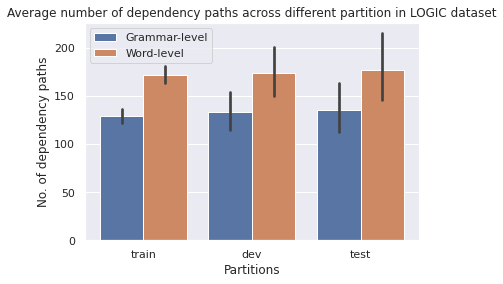

In [11]:
# Plot number of dependency paths observed across each partition

def plot_n_dependency_paths():
    data = {
        'partition': [],
        'n_dependencies': [],
        'type': [], # Word-level or Grammar-level
    }

    for partition in ('train', 'dev', 'test'):
        collection = eval(f'{partition}_parsed_ord', globals(), locals())
        for dependency_structure in collection:
            data['partition'].append(partition)
            data['n_dependencies'].append(len(dependency_structure.keys()))
            data['type'].append('Grammar-level')

            word_level_count = 0
            for word_level_dependency_structure in dependency_structure.values():
                word_level_count += len(word_level_dependency_structure)
            data['partition'].append(partition)
            data['n_dependencies'].append(word_level_count)
            data['type'].append('Word-level')
    
    fig, ax = plt.subplots()
    sns.barplot(data=data, x='partition', y='n_dependencies', hue='type', ax=ax)
    ax.set_title('Average number of dependency paths across different partition in LOGIC dataset')
    ax.set_xlabel('Partitions')
    ax.set_ylabel('No. of dependency paths')
    ax.set_label('Level')
    plt.plot()

plot_n_dependency_paths()


In [12]:
# We are using TF-IDF to rank dependencies, instead of just sorting them
# by their frequency.

def _gen_idf_from_training_samples(train_dependency_structure_list) -> dict:
    idf_dict = dict()
    for dependency_structure in train_dependency_structure_list:
        for w in dependency_structure.keys():
            if w not in idf_dict:
                idf_dict[w] = 0
            idf_dict[w] += 1
    return idf_dict

GLOBAL_IDF_DICT = _gen_idf_from_training_samples(train_parsed_ord)
print(len(GLOBAL_IDF_DICT))

77648


In [13]:
def generate_top_k_dependencies_by_tf_idf(train_dependency_structure_list,
                                     test_dependency_structure,
                                     k=-1):
    """Generate top K dependencies for a test comment using TF-IDF on train comments

    :param train_dependency_structure_list: list of dependency structure for training examples
    :type train_dependency_structure_list: list
    :param test_dependency_structure: dependency structure for test example
    :type test_dependency_structure: dict
    :param k: value of `k` in top `k`, defaults to -1
    :type k: int, optional
    """

    # Computation for IDF from training partition
    n_documents = len(train_dependency_structure_list) + 1
    n_documents_containing_w = deepcopy(GLOBAL_IDF_DICT)

    # for dependency_structure in train_dependency_structure_list:
    #     n_documents += 1
    #     for w in dependency_structure.keys():
    #         if w not in n_documents_containing_w:
    #             n_documents_containing_w[w] = 0
    #         n_documents_containing_w[w] += 1

    # Computation for IDF and TF from the given test example
    total_w_in_test = 0
    n_instance_of_w_in_test = dict()
    
    for w in test_dependency_structure.keys():
        if w not in n_documents_containing_w:
            n_documents_containing_w[w] = 0
        n_documents_containing_w[w] += 1

        w_count = len(test_dependency_structure[w])
        total_w_in_test += w_count
        if w not in n_instance_of_w_in_test:
            n_instance_of_w_in_test[w] = 0
        n_instance_of_w_in_test[w] += w_count 
    
    w_with_tf_idf_score = list()
    for w in test_dependency_structure.keys():
        tf = n_instance_of_w_in_test[w] / total_w_in_test
        idf = np.log(n_documents / n_documents_containing_w[w])
        score = tf * idf 
        w_with_tf_idf_score.append((w, score))

    
    w_with_tf_idf_score = sorted(w_with_tf_idf_score, key=lambda z: z[1], reverse=True)
    if k != -1:
        w_with_tf_idf_score = w_with_tf_idf_score[:k]

    for dependency, tf_idf_score in w_with_tf_idf_score:
        yield dependency, tf_idf_score

100%|██████████| 300/300 [01:33<00:00,  3.20it/s]


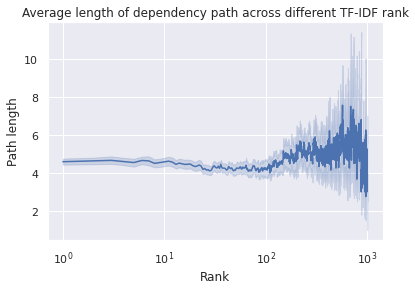

In [21]:
def plot_path_length_vs_tf_idf_rank():
    data = {
        'rank': [],
        'path_length': [],
    }

    for i in tqdm(range(len(test_parsed_ord))):
        for rank, (dependency, tf_idf_score) in enumerate(generate_top_k_dependencies_by_tf_idf(train_parsed_ord, test_parsed_ord[i])):
            if rank < 1000:
                data['rank'].append(rank + 1) # 1-indexed
                data['path_length'].append(len(dependency))

    fig, ax = plt.subplots()
    sns.lineplot(data=data, x='rank', y='path_length', ax=ax)
    ax.set_title('Average length of dependency path across different TF-IDF rank')
    ax.set_xlabel('Rank')
    ax.set_xscale('log')
    ax.set_ylabel('Path length')
    plt.plot()

plot_path_length_vs_tf_idf_rank()

In [16]:
def create_auxiliary_text(text, parsed, n=-1):
    """Create auxiliary sentences from dependency parsing

    n:
        number of auxiliary texts to generate, -1 for all
    """
    doc = scapy_nlp(text.lower())
    tokens = [token.text for token in doc]
    auxiliary_texts = list()

    for path, _ in generate_top_k_dependencies_by_tf_idf(train_parsed_ord, parsed, n):
        if len(auxiliary_texts) == n:
            break

        local_list = []

        for token in path:
            detailed_token = token
            if detailed_token:
                local_list.append(detailed_token)
        

        auxiliary_texts.append(','.join(local_list))

    main_txt = ' '.join(tokens)
    aux_txt  = ','.join(auxiliary_texts)
    
    return main_txt, aux_txt


In [17]:
foo, bar = create_auxiliary_text(test_texts[0], test_parsed_ord[0], 2)
print(foo)
print(bar)

people who drive big cars probably hate the environment .
amod,dobj,relcl,nsubj,dobj,det,dobj,nsubj,relcl,dobj


In [18]:
def create_auxiliary_texts(texts, parsed_ord, n=-1):
    """Create auxiliary sentences 

    texts:
        train_texts / test_texts / dev_texts

    parsed_ord:
        train_parsed_ord / test_parsed_ord / dev_parsed_ord

    n:
        number of auxiliary texts to generate per entry, -1 for all
    """
    assert(len(texts) == len(parsed_ord))

    result = []

    for text, parsed in tqdm(zip(texts, parsed_ord), total=len(texts)):
        result.append(create_auxiliary_text(text, parsed, n))
    return result

In [19]:
N = [1, 2, 3, 4, 5, 10, 20, -1]

for n in N:
    print(f'n = {n}')
    train_aux = create_auxiliary_texts(train_texts, train_parsed_ord, n=n)
    test_aux  = create_auxiliary_texts(test_texts,  test_parsed_ord,  n=n)
    dev_aux   = create_auxiliary_texts(dev_texts,   dev_parsed_ord,   n=n)
    result = (train_aux, test_aux, dev_aux)
    save_obj(result, f'./dataset/aux-sentences-n-{n}-simple.pkl')

n = 1


100%|██████████| 300/300 [01:36<00:00,  3.12it/s]


n = 2


100%|██████████| 300/300 [01:37<00:00,  3.06it/s]


n = 3


100%|██████████| 300/300 [01:37<00:00,  3.07it/s]


n = 4


100%|██████████| 300/300 [01:35<00:00,  3.13it/s]


n = 5


100%|██████████| 300/300 [01:35<00:00,  3.14it/s]


n = 10


100%|██████████| 300/300 [01:35<00:00,  3.13it/s]


n = 20


100%|██████████| 300/300 [01:35<00:00,  3.13it/s]


n = -1


100%|██████████| 300/300 [01:35<00:00,  3.14it/s]
